<a href="https://colab.research.google.com/github/Valentina-Gol/math_packages_leti/blob/main/lab1/math_package_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1

**Цель работы**  
Изучить возможности библиотек Python для решения задач цифровой
обработки сигналов.

**Задачи лабораторной работы**
1.  Освоить Jupyter Notebook.  
2.  Выполнить загрузку аудио сигнала и построить огибающую (график).  
3.  Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный
сигнал.  
4.  Детектор сигнал/шум. Получить сигнал после детектирования.  
5.  Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6.  Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

In [4]:
from google.colab import drive
drive.mount('/content/drive/') # монтируем папку своего гугл диска

Mounted at /content/drive/


In [5]:
from scipy.io import  wavfile
import scipy.io
# загружаем исходный звуковой сигнал
sample_rate, data = wavfile.read('/content/drive/MyDrive/Colab_Notebooks/03-01-05-01-01-02-03_A3.wav')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  after removing the cwd from sys.path.


## Загрузка аудио сигнала и построение огибающей кривой

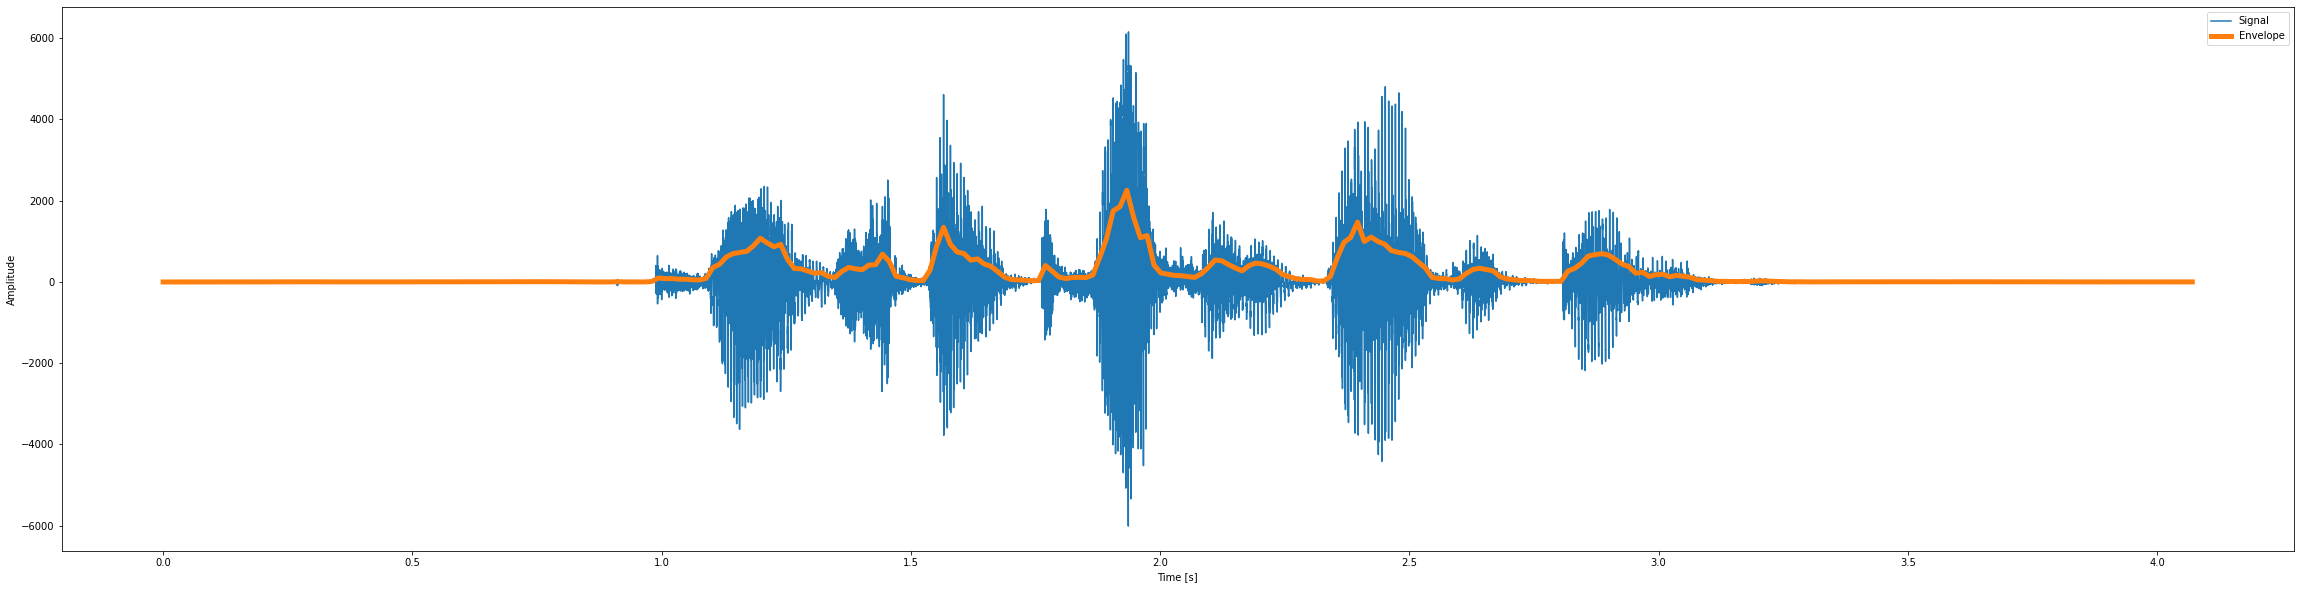

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# устанавливаем количество точек для построения кривой
num_dots = 300
length_signal = data.shape[0] / sample_rate
time = np.linspace(0, length_signal, data.shape[0])
m = int(data.shape[0] / num_dots)
curve = np.linspace(0, length_signal, num_dots)
curve_values = []
# считаем значения для кривой
for j in range(num_dots):
  sum = 0
  for k in range(m * j, m * j + m):
    sum += abs(data[k])
  curve_values.append(sum / m)
  
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, data, label="Signal")
plt.plot(curve, curve_values, label="Envelope", linewidth=5)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Фильтрация сигнала

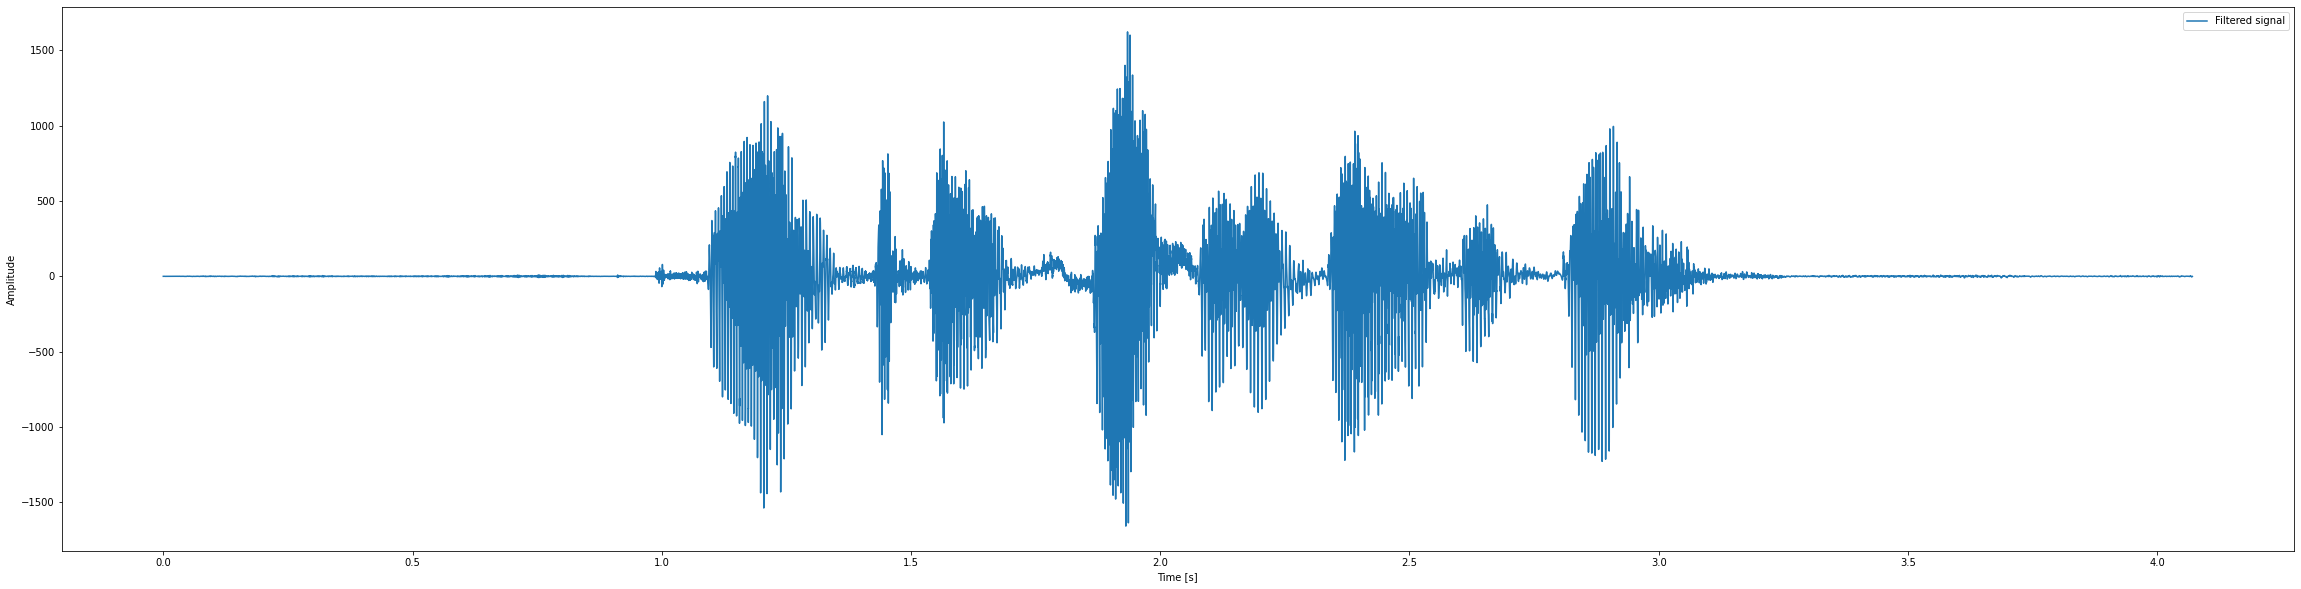

In [39]:
from scipy import signal
# выбираем значения частоты среза и порядок фильтра
Fs = 500
m = 1
wn = 2 * Fs / sample_rate
# применяем фильтр нижних частот
b, a = signal.butter(m, wn, 'lowpass')
filtered_data = signal.filtfilt(b, a, data)

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, filtered_data, label="Filtered signal")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Детектор сигнал/шум

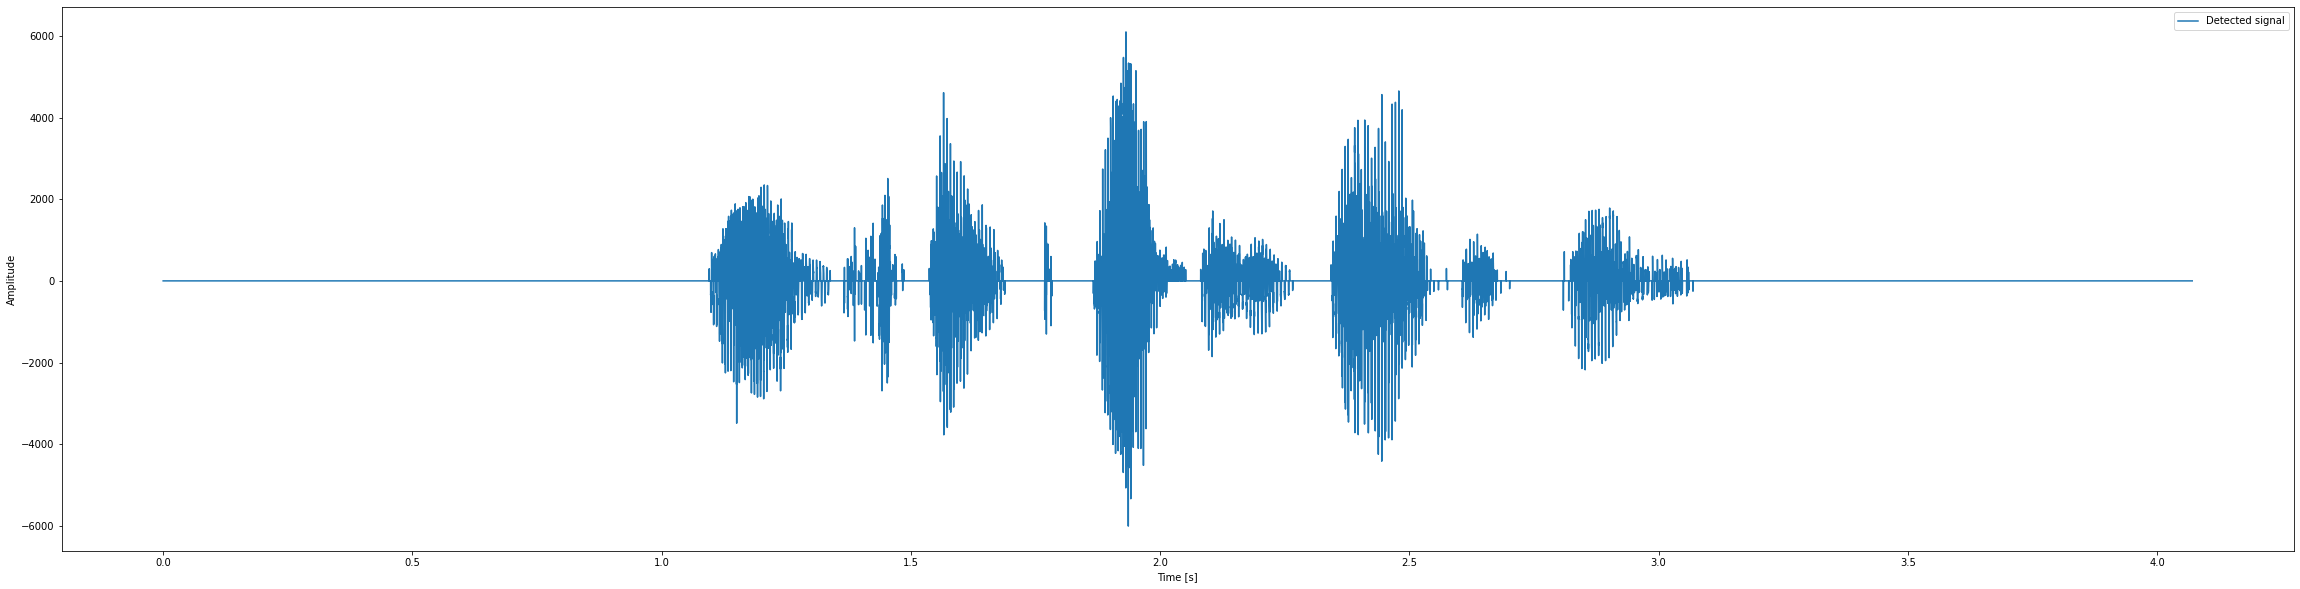

In [8]:
mid = 0
# определяем порог детектора
for k in range(data.shape[0]):
  mid += abs(data[k])
mid = mid / data.shape[0]
alpha = 0.9
Th = alpha * mid

k = 10
yi = np.zeros(data.shape[0])
is_signal = False
counter_signal = 0
counter_no_signal = 0
# детектируем события начала и окончания сигнала
for ind in range(data.shape[0]):
  if abs(data[ind]) > Th:
    counter_signal += 1
    counter_no_signal = 0
    if counter_signal >= k:
      is_signal = True
      yi[ind] = data[ind]
  else:
    counter_no_signal += 1
    counter_signal = 0
    if counter_no_signal >= k:
      is_signal = False

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, yi, label="Detected signal")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Эффект ”Эхо”

In [ ]:
# задали коэффициенты линий задержки и коэффициент применимости------------------------
a1, a2, a3, a4, a5, a6, a7, a8 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
gamma = 0.8
# выбор режима и установка величины задержки
work_mode = "preset" # or manual-----------------------
D1, D2, D3, D4, D5, D6, D7, D8 = [0, 0, 0, 0, 0, 0, 0, 0]

if mode == "preset":
  #D1 = int(input("Введите максимальную задержку D1"))
  D1 = 4
  D2 = D1 * 2 ** (-1 / 8)
  D3 = D1 * 2 ** (-2 / 8)
  D4 = D1 * 2 ** (-3 / 8)
  D5 = D1 * 2 ** (-4 / 8)
  D6 = D1 * 2 ** (-5 / 8)
  D7 = D1 * 2 ** (-6 / 8)
  D8 = D1 * 2 ** (-7 / 8)
'''

elif mode == "manual":
'''  

# выбираем значения частоты среза и порядок фильтра
Fs = 600
m = 1
wn = 2 * Fs / sample_rate
# применяем фильтр нижних частот
b, a = signal.butter(m, wn, 'lowpass')
filtered_data = signal.filtfilt(b, a, data)


'''
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, yi, label="Detected signal")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()
'''

## Эффект ”Distortion”

In [ ]:
Th = int(input("Введите порог"))
Max = int(input("Введите максимальное значение сигнала"))

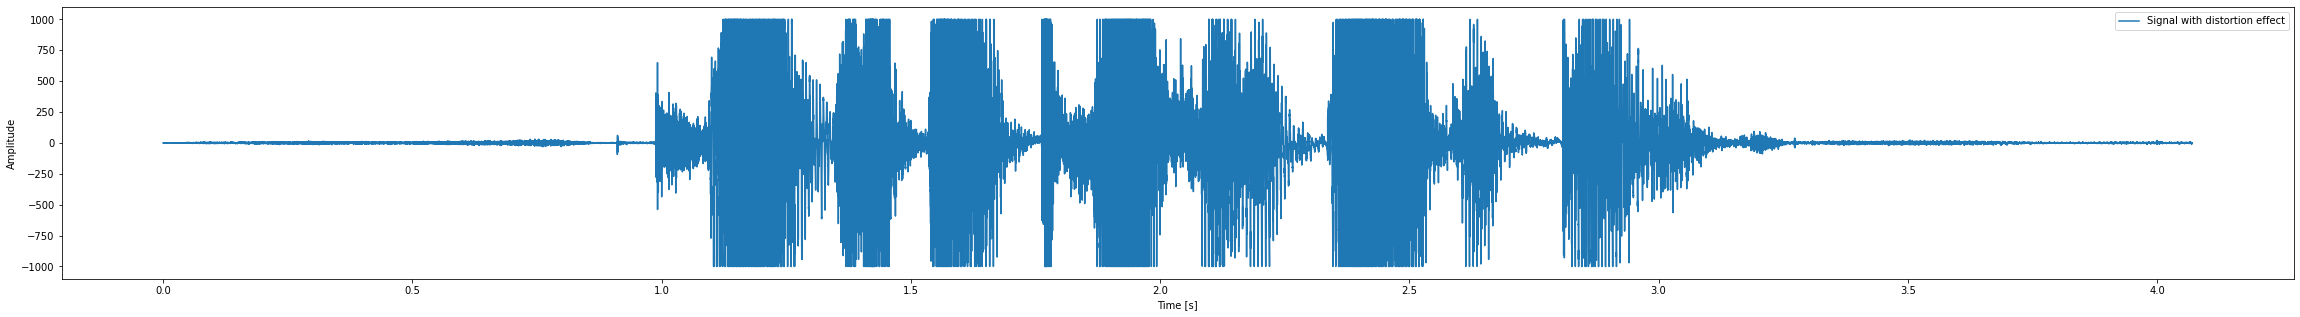

In [41]:
def sign(value) -> int:
  if value < 0:
    return -1
  elif value > 0:
    return 1
  return 0    

yi = np.zeros(data.shape[0])
# ограничиваем сигнал по амплитуде
for ind in range(data.shape[0]):
  if abs(data[ind]) < Th or abs(data[ind]) < Max:
    yi[ind] = data[ind]
  else:
    yi[ind] = Max * sign(data[ind])
   
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(5)
plt.plot(time, yi, label="Signal with distortion effect")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()    